In [1]:
import numpy as np
import pandas as pd
import cbsodata
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
#toc = pd.DataFrame(cbsodata.get_table_list())
#toc

In [3]:
data = pd.DataFrame(cbsodata.get_data('70895ned'))
data.dropna(subset = ["Overledenen_1"], inplace=True)
df=data[data.Perioden.str.contains('week')]
df=df[df.Perioden.str.contains('1995 week 0')==False].reset_index(drop=True)
df.iloc[1382:1392]

,ID,Geslacht,LeeftijdOp31December,Perioden,Overledenen_1
1382,1409,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 4,3706.0
1383,1410,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 5,3647.0
1384,1411,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 6,3543.0
1385,1412,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 7,3514.0
1386,1413,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 8,3195.0
1387,1414,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 9,3083.0
1388,1415,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 10,3211.0
1389,1416,Totaal mannen en vrouwen,Totaal leeftijd,2021 week 11,3084.0
1390,1418,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 1,476.0
1391,1419,Totaal mannen en vrouwen,0 tot 65 jaar,1995 week 2,511.0


In [4]:
df_clean = df.drop(columns = ['ID'])
df_clean['to_first_week']=df_clean.Perioden.str.contains('dag') & df_clean.Perioden.str.contains('week 1')
df_clean['to_last_week']=df_clean.Perioden.str.contains('dag') & df_clean.Perioden.shift(-1).str.contains('week 0')
df_clean['partial_week']=df_clean.Perioden.str.contains('dag')
df_clean.loc[df_clean['to_first_week'] == True, 'deaths'] = df_clean['Overledenen_1'].shift(+1) + df_clean['Overledenen_1'] 
df_clean.loc[df_clean['to_last_week'] == True, 'deaths'] = df_clean['Overledenen_1'].shift(-1) + df_clean['Overledenen_1'] 
df_clean.loc[df_clean['partial_week'] == False, 'deaths'] = df_clean['Overledenen_1']
df_clean = df_clean.dropna(subset = ["deaths"]).reset_index(drop=True)
df_clean[['year','week']] = df_clean.Perioden.str.split("week",expand=True)
df_clean['week'] = df_clean.week.str.extract('(\d+)')
df_clean['year'] = df_clean.year.str.extract('(\d+)')
df_clean = df_clean.drop(columns = ['Overledenen_1','to_first_week','to_last_week','partial_week'])
df_clean = df_clean.rename(columns={"LeeftijdOp31December": "age", "Geslacht": "gender"})
df_clean = df_clean[['Perioden','gender','age','year','week','deaths']]

#remove this line to get the full time period
df_clean=df_clean[df_clean.Perioden >= '2011'].reset_index(drop=True)

df_clean['covid_year']=df_clean['year'] >= '2020'
df_clean.loc[df_clean['covid_year'] == False, 'covid_year'] = '1995-2019 +/- SD'
df_clean.loc[df_clean['covid_year'] == True, 'covid_year'] = df_clean['year']

df_clean.iloc[1:10]

,Perioden,gender,age,year,week,deaths,covid_year
1,2011 week 2,Totaal mannen en vrouwen,Totaal leeftijd,2011,2,2819.0,1995-2019 +/- SD
2,2011 week 3,Totaal mannen en vrouwen,Totaal leeftijd,2011,3,2624.0,1995-2019 +/- SD
3,2011 week 4,Totaal mannen en vrouwen,Totaal leeftijd,2011,4,2620.0,1995-2019 +/- SD
4,2011 week 5,Totaal mannen en vrouwen,Totaal leeftijd,2011,5,2728.0,1995-2019 +/- SD
5,2011 week 6,Totaal mannen en vrouwen,Totaal leeftijd,2011,6,2675.0,1995-2019 +/- SD
6,2011 week 7,Totaal mannen en vrouwen,Totaal leeftijd,2011,7,2621.0,1995-2019 +/- SD
7,2011 week 8,Totaal mannen en vrouwen,Totaal leeftijd,2011,8,2651.0,1995-2019 +/- SD
8,2011 week 9,Totaal mannen en vrouwen,Totaal leeftijd,2011,9,2686.0,1995-2019 +/- SD
9,2011 week 10,Totaal mannen en vrouwen,Totaal leeftijd,2011,10,2714.0,1995-2019 +/- SD


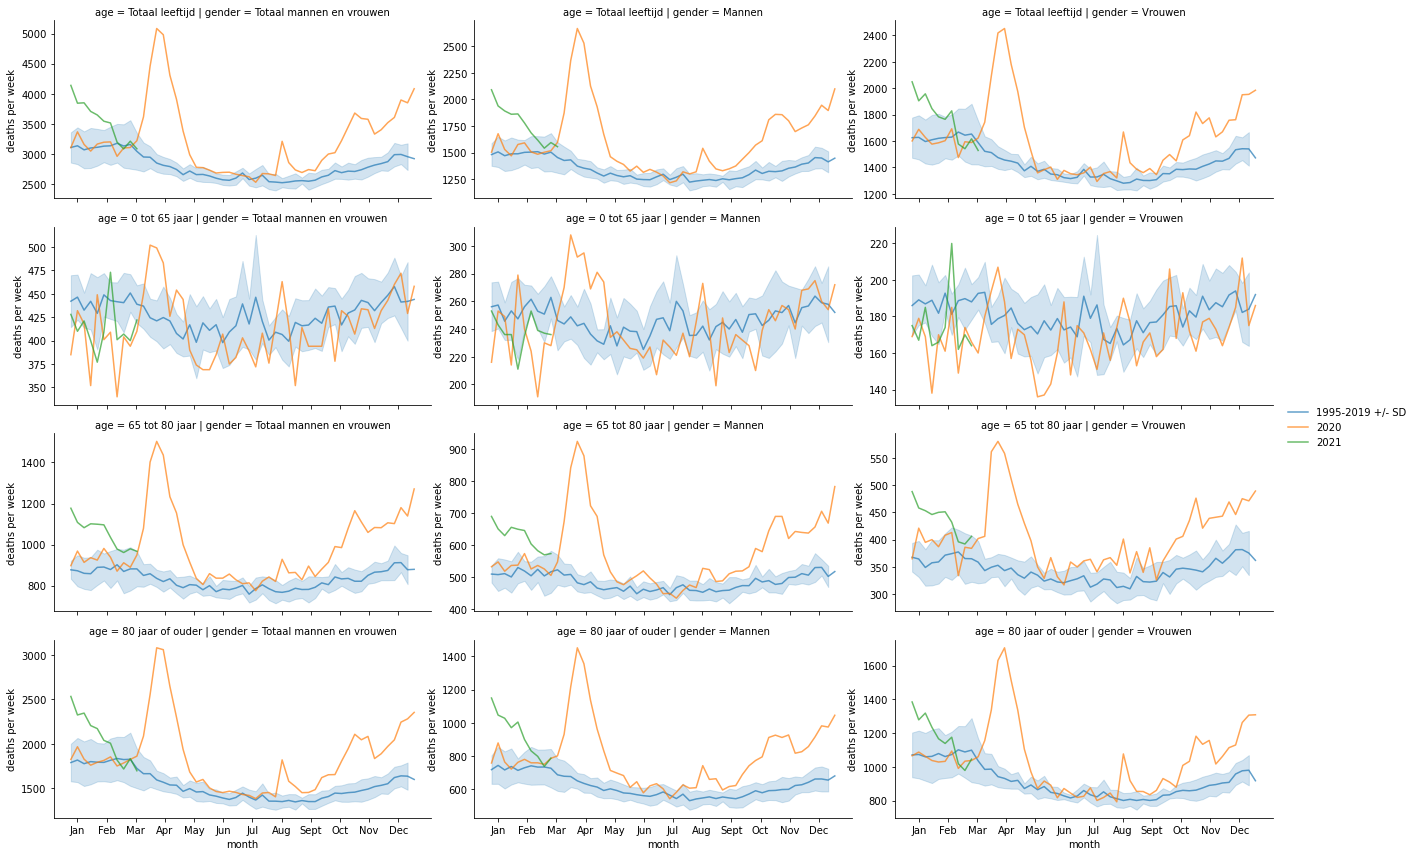

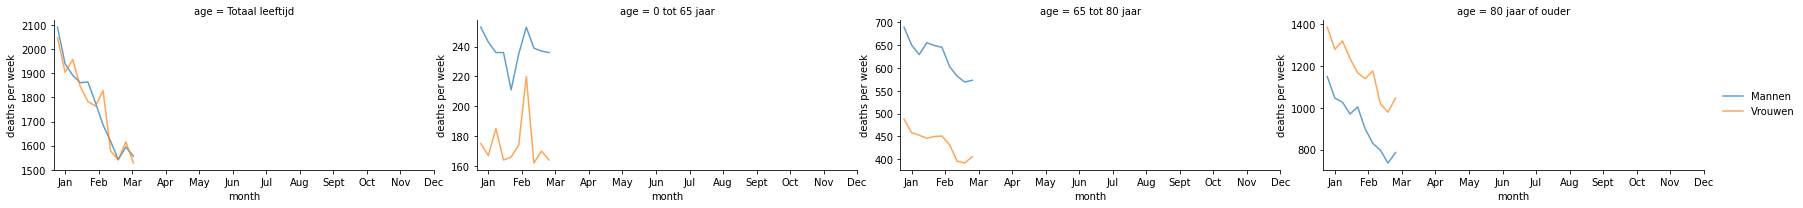

In [5]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

g = sns.FacetGrid(df_clean, col="gender", hue="covid_year", row='age', aspect=2,sharey=False)
g.map(sns.lineplot, 'week', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="month", ylabel = "deaths per week", xticks=np.arange(1, 53,(53/12) ), xticklabels=months)
g.add_legend(title = '')
g.savefig('naar_Geslacht_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

g = sns.FacetGrid(df_clean.query("year == '2021' & gender !='Totaal mannen en vrouwen'"), col="age", hue="gender", aspect=2,sharey=False)
g.map(sns.lineplot, 'week', 'deaths', alpha=.7)
g.set(xlabel="month", ylabel = "deaths per week", xticks=np.arange(1, 53,(53/12) ), xticklabels=months)
g.add_legend(title = '')
g.savefig('2021_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

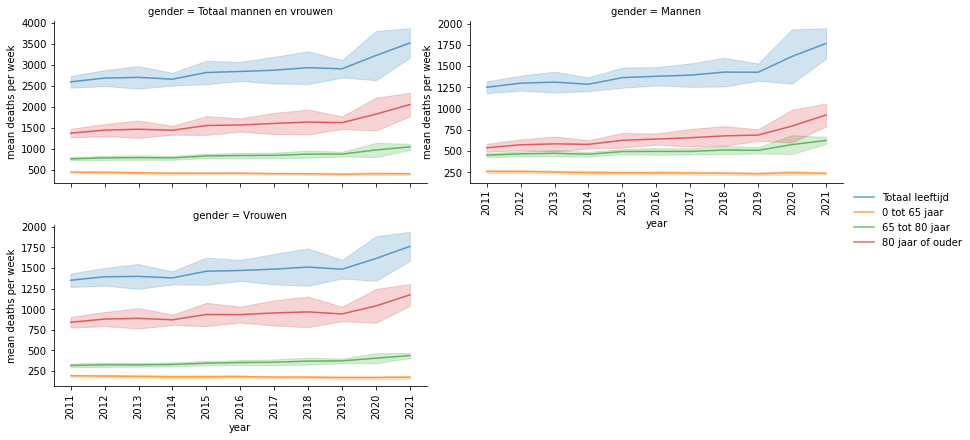

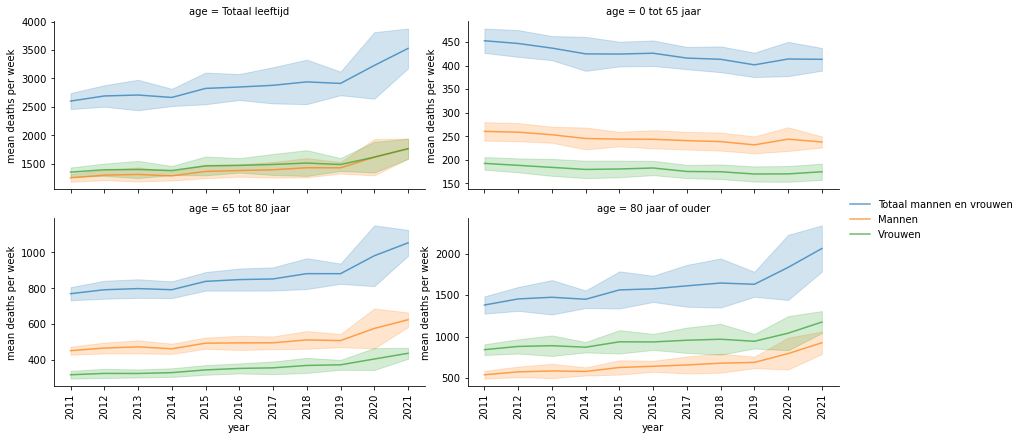

In [6]:
g = sns.FacetGrid(df_clean, col="gender", hue="age", col_wrap=2, aspect=2,sharey=False)
g.map(sns.lineplot, 'year', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="year", ylabel = "mean deaths per week")
g.set_xticklabels(rotation=90)
g.add_legend(title = '')
g.savefig('perjaar_Geslacht.png', dpi=300, bbox_inches='tight', facecolor='white')

g = sns.FacetGrid(df_clean, col="age", hue="gender",col_wrap=2, aspect=2,sharey=False)
g.map(sns.lineplot, 'year', 'deaths', alpha=.7, estimator='mean', ci='sd')
g.set(xlabel="year", ylabel = "mean deaths per week")
g.set_xticklabels(rotation=90)
g.add_legend(title = '')
g.savefig('perjaar_leeftijd.png', dpi=300, bbox_inches='tight', facecolor='white')

In [7]:
leeftijd='Totaal leeftijd'
#leeftijd='0 tot 65 jaar'
#leeftijd='65 tot 80 jaar'
#leeftijd='80 jaar of ouder'
sex='Totaal mannen en vrouwen'
#sex='Mannen'
#sex='Vrouwen'

df_circle=df_clean[(df_clean.age == leeftijd) & (df_clean.gender == sex)]
df_circle = df_circle.groupby('Perioden').sum().squeeze()
df_circle

Perioden
2011 week 1     2917.0
2011 week 10    2714.0
2011 week 11    2727.0
2011 week 12    2686.0
2011 week 13    2739.0
                 ...  
2021 week 5     3647.0
2021 week 6     3543.0
2021 week 7     3514.0
2021 week 8     3195.0
2021 week 9     3083.0
Name: deaths, Length: 533, dtype: float64

In [8]:
deaths_per_year = pd.DataFrame(columns=range(2011, 2021+1), index=pd.RangeIndex(1, 53+1, name='week'))

for Perioden, deaths in df_circle.iteritems():
    year = int(Perioden[0:4])
    week = int(Perioden[9:12])
    deaths_per_year.loc[week, year] = deaths
    
deaths_per_year

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
week,,,,,,,,,,,
1,2917.0,2930.0,2947.0,2766.0,3255.0,3173.0,3568.0,3343.0,3062.0,3105.0,4139.0
2,2819.0,2773.0,3038.0,2819.0,3429.0,3075.0,3637.0,3359.0,3262.0,3366.0,3843.0
3,2624.0,2785.0,3011.0,2740.0,3377.0,3062.0,3487.0,3364.0,3152.0,3157.0,3849.0
4,2620.0,2789.0,3082.0,2710.0,3353.0,3201.0,3626.0,3322.0,3179.0,3046.0,3706.0
5,2728.0,2815.0,3192.0,2708.0,3322.0,3103.0,3574.0,3403.0,3139.0,3163.0,3647.0
6,2675.0,3034.0,3143.0,2855.0,3272.0,3036.0,3446.0,3513.0,3183.0,3194.0,3543.0
7,2621.0,3089.0,3033.0,2796.0,3311.0,3027.0,3417.0,3660.0,3254.0,3199.0,3514.0
8,2651.0,3035.0,3211.0,2753.0,3381.0,3319.0,3328.0,3691.0,3220.0,2959.0,3195.0
9,2686.0,3061.0,3170.0,2713.0,3207.0,3185.0,3152.0,3937.0,3065.0,3098.0,3083.0


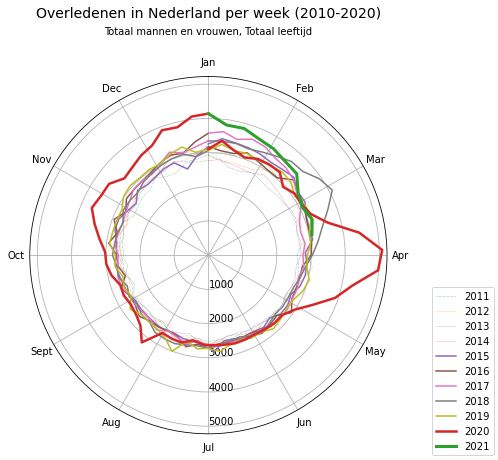

In [9]:
def data_for_year(y):
    year = deaths_per_year[y].dropna().to_numpy()
    if y == 2021:
        num_weeks = len(year)
        day_of_the_year = num_weeks*7 + 3 # ex. week 46 -> november 15 -> day 319
        theta = np.linspace(0, (day_of_the_year/365)*2*np.pi, num_weeks)
    else:
        # append first week of next year for correct radial plotting
        year = np.append(year, deaths_per_year.loc[1, y+1])
        theta = np.linspace(0, 2*np.pi, len(year))
    return (theta, year)

def plot_year(ax, y, **kwargs):
    ax.plot(*data_for_year(y), label=f"{y}", **kwargs)

def setup_polar_plot(figsize=(8, 6), constrained_layout=True):
    fig = plt.figure(figsize=figsize, constrained_layout=constrained_layout)
    ax = fig.add_subplot(111, projection='polar')

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_xticks(np.arange(0, 2*np.pi, np.pi/6))
    ax.set_xticklabels(months)

    ax.set_rlabel_position(180)
#    ax.set_yticklabels(['1000', '2000', '3000', '4000', '5000', ''])

    return fig, ax

fig, ax = setup_polar_plot()
plot_year(ax, 2011, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2012, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2013, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2014, linewidth=0.5, linestyle='dotted')
plot_year(ax, 2015, linewidth=1.5)
plot_year(ax, 2016, linewidth=1.5)
plot_year(ax, 2017, linewidth=1.5)
plot_year(ax, 2018, linewidth=1.5)
plot_year(ax, 2019, linewidth=1.5)
plot_year(ax, 2020, color='tab:red', linewidth=2.5)
plot_year(ax, 2021, color='tab:green', linewidth=3)

#plot_year(ax, 2011, color='tab:gray', linewidth=0.5)
#plot_year(ax, 2012, color='tab:gray', linestyle='dotted')
#plot_year(ax, 2013, color='tab:gray', linestyle='dashed')
#plot_year(ax, 2014, color='tab:gray', linestyle='dashdot')
#plot_year(ax, 2015, color='tab:gray')
#plot_year(ax, 2016, color='tab:blue', linestyle='dashdot')
#plot_year(ax, 2017, color='tab:blue')
#plot_year(ax, 2018, color='tab:green')
#plot_year(ax, 2019, color='tab:orange')
#plot_year(ax, 2020, color='tab:red', linewidth=3)

#ax.set_rmax(5500)
fig.legend(loc='lower right')
fig.suptitle("Overledenen in Nederland per week (2010-2020)", fontsize=14, y=1.04)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)

plt.savefig('sterfte_perjaar.png', dpi=300, bbox_inches='tight', facecolor='white')

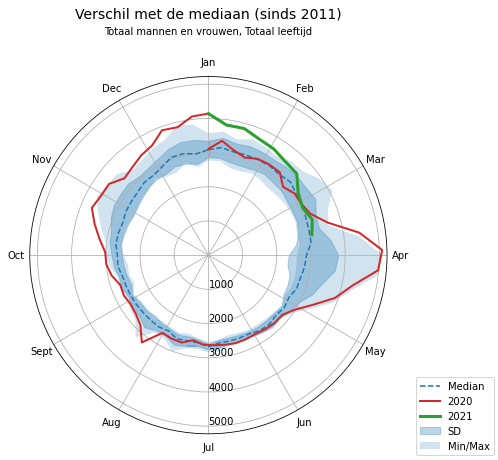

In [10]:
years = deaths_per_year.iloc[:, :-1] # excluding 2021

mean = years.mean(skipna=True,axis=1)
mean[53] = mean[1]

median = years.median(skipna=True,axis=1)
median[53] = median[1]

min = years.min(axis=1)
min[53] = min[1]

max = years.max(axis=1)
max[53] = max[1]

sd = years.std(axis=1)
sd[53] = sd[1]

q25 = deaths_per_year.astype(float).quantile(0.25, axis=1)
q25[53] = q25[1]

q75 = deaths_per_year.astype(float).quantile(0.75, axis=1)
q75[53] = q75[1]

fig, ax = setup_polar_plot()

# ax.plot(np.linspace(0, 2*np.pi, len(mean)), mean, label="5y mean")
# ax.plot(np.linspace(0, 2*np.pi, len(data_for_year(2019))), data_for_year(2019), label="2019")
ax.fill_between(np.linspace(0, 2*np.pi, len(min)), mean+sd, mean-sd, alpha=0.3, label="SD", color='tab:blue')

ax.fill_between(np.linspace(0, 2*np.pi, len(min)), min, max, alpha=0.2, label="Min/Max")
#ax.fill_between(np.linspace(0, 2*np.pi, len(q25)), q25, q75, alpha=0.3, label="50%", color='tab:green')

ax.plot(np.linspace(0, 2*np.pi, len(median)), median, label="Median", linestyle='dashed')
plot_year(ax, 2020, color='tab:red', linewidth=2)
plot_year(ax, 2021, color='tab:green', linewidth=3)


#ax.set_rmax(5500)
fig.legend(loc='lower right')
fig.suptitle(f"Verschil met de mediaan (sinds 2011)", fontsize=14, y=1.04)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)

plt.savefig('sterfte_median.png', dpi=300, bbox_inches='tight', facecolor='white')

done


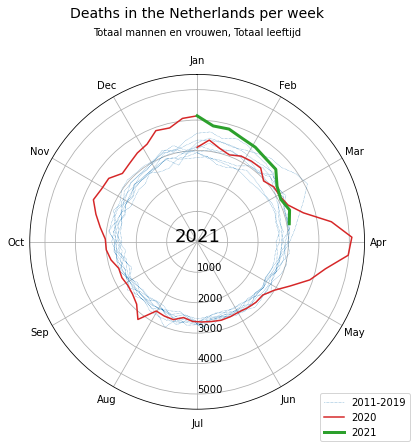

In [11]:
start_year = 2011

fig, ax = setup_polar_plot(figsize=(6, 6.2), constrained_layout=False)

# english month labels
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# nudge ax position
pos = ax.get_position()
pos.y0 -= 0.05
pos.y1 -= 0.05
pos.x0 -= 0.012
pos.x1 -= 0.012
ax.set_position(pos)

fig.suptitle("Deaths in the Netherlands per week", fontsize=14)
ax.set_title(f"{sex}, {leeftijd}", fontsize=10, y=1.1)


old, = ax.plot([], [], color='tab:blue', linewidth=0.5, linestyle='dotted', label="2011-2019")
prev, = ax.plot([], [], color='tab:red', label="2020")
current, = ax.plot([], [], color='tab:green', linewidth=3, label="2021")
center = ax.text(0, 25, "5000", horizontalalignment='center', fontsize=18)
ax.set_rmax(5500)

def year_and_week_for_index(i):
    y = start_year
    while True:
        len_year = len(deaths_per_year[y].dropna()) + 1
        if len_year > i:
            return (y, i+1)
        else:
            y += 1
            i -= (len_year-1)

def data_for_index(i):
    y, w = year_and_week_for_index(i)
    #print(y, w)
    theta, year = data_for_year(y)
    return theta[:w], year[:w]

def init():
    old.set_data([], []) 
    prev.set_data([], []) 
    current.set_data([], []) 
    center.set_text("")
    return old, prev, current, center

def animate(i):
    y = year_and_week_for_index(i)[0]

    if y > start_year:
        old_theta = np.array([])
        old_data = np.array([])
        for year in range(start_year, y-1):
            theta, data = data_for_year(year)
            old_theta = np.append(old_theta, theta)
            old_data = np.append(old_data, data)
        old.set_data(old_theta, old_data)
        prev.set_data(*data_for_year(y-1))

    current.set_data(*data_for_index(i))
    center.set_text(f"{y}")
    return old, prev, current, center

num_frames = len(df_circle)

anim = mpl.animation.FuncAnimation(fig, animate, init_func=init, frames=num_frames, interval=50, blit=True) 
anim.save('sterfte_anim.mp4', writer='ffmpeg', dpi=300, extra_args=['-vf', 'tpad=stop_mode=clone:stop_duration=5'])
#anim.save(f"img/{sex}_{leeftijd}_anim.gif", writer='imagemagick', dpi=72, fps=30, savefig_kwargs={'facecolor': 'white'})

fig.legend(loc='lower right')
plt.savefig('sterfte_anim.png', dpi=300, bbox_inches='tight', facecolor='white')
print("done")

In [12]:
import ffmpeg
(
    ffmpeg
    .input('sterfte_anim.mp4')
    .output('sterfte_anim.gif')
    .run(overwrite_output=True)
)

(None, None)